<a href="https://colab.research.google.com/github/StevTMU/AI_CUP_2023_Spring/blob/main/TEAM_3693_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

這個範例參考自 
- Tensorflow 官方範例 https://www.tensorflow.org/tutorials/audio/simple_audio  
- Keras 官方範例 https://keras.io/examples/audio/speaker_recognition_using_cnn/  
- Python 使用 librosa 分析聲音訊號 https://officeguide.cc/python-librosa-package-analysis-music-and-audio-tutorial-examples/

In [ ]:
# 掛載雲端硬碟 Mount google drive in CoLab enviroment
from google.colab import drive
drive.mount('gdrive')

Mounted at gdrive


# ~ 環境準備

In [ ]:
colab_requirements = [
    "pip install librosa",
    "pip install noisereduce",
    "pip install soundfile",

]

import sys, subprocess

def run_subprocess_command(cmd):
    # run the command
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
    # print the output
    for line in process.stdout:
        print(line.decode().strip())

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    for i in colab_requirements:
        run_subprocess_command(i)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# 匯入需要的 python 模組
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import tensorflow as tf  
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import layers, callbacks, regularizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from IPython import display
# 聲音套件 https://librosa.org/doc/main/index.html  
import librosa
import librosa.display
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, recall_score
from itertools import cycle, product
from scipy import interp

In [ ]:
import IPython
from scipy.io import wavfile
import noisereduce as nr
import soundfile as sf
from noisereduce.generate_noise import band_limited_noise
import urllib.request
import io
import glob
from scipy import signal

In [ ]:
# 變更工作資料夾 --> 自己組別的資料夾 ex."/content/gdrive/Shareddrives/1112_AI智慧醫療三日工作坊/第01大組_"
my_working_root = "/content/gdrive/Shareddrives/1112_AI智慧醫療三日工作坊/第04大組_Pony小馬車"
os.chdir(my_working_root)

# 1 資料處理
|變項(中文)|變項(英文)|Coding|說明(中文)|說明(英文)|
|---|---|---|---|---|
|嗓音診斷分類(target)|Disease category|1/2/3/4/5|嗓音誤用/聲帶閉合不全/聲帶麻痺/聲帶腫瘤/聲帶正常|Phonotrauma/Incomplete glottic closure/Vocal palsy/Neoplasm/Normal|
|性別|Sex|1/2|男性/女性|Male/Female
|年齡|Age|numbers| |  	
|音域變窄|Narrow pitch range|0/1|無/有|No/Yes
|說話音量變小|Decreased volume|0/1|無/有|No/Yes
|說話久了容易累|Fatigue|0/1|無/有|No/Yes
|喉嚨常覺得乾|Dryness|0/1|無/有|No/Yes
|喉嚨有異物感|Lumping|0/1|無/有|No/Yes
|胸口有灼熱感|Heartburn|0/1|無/有|No/Yes
|吞東西容易嗆到|Choking|0/1|無/有|No/Yes
|眼睛乾澀|Eye dryness|0/1|無/有|No/Yes
|鼻涕倒流|PND|0/1|無/有|No/Yes
|糖尿病|Diabetes|0/1|無/有|No/Yes
|高血壓|Hypertension|0/1|無/有|No/Yes
|心臟病|CAD|0/1|無/有|No/Yes
|頭頸部腫瘤|Head and Neck Cancer|0/1|無/有|No/Yes
|頭部損傷|Head injury|0/1|無/有|No/Yes
|腦中風|CVA|0/1|無/有|No/Yes
|抽菸|Smoking|0/1/2/3|從未/已戒菸/有抽菸/電子菸|Never/past/active/e-cigarette
|PPD|PPD|numbers|一天幾包菸|pack (of cigarrette) per day
|喝酒|Drinking|0/1/2|從未喝酒/已戒酒/有喝酒|Never/past/active 
|喝酒頻率|Frequency|0/1/2/3|偶爾喝/每周喝/幾乎每天|Not/occasionally/ weekly/daily 
|症狀如何發生的|Onset of dysphonia|1/2/3/4/5|突然/逐漸變差/時好時壞/從小開始/其他|Sudden/Gradually/On and off/Since childhood/Other 
|工作環境是否吵雜|Noise at work|1/2/3|否/有一點/很吵|Not/a little/noisy 
|聲音何時最差|Diurnal pattern|1/2/3/4|早上/下午、晚上 /都一樣/不一定|Worse in the morning/Worse in the afternoon/Similar all day/Fluctuating 
|用聲情形|Occupational vocal demand|1/2/3/4|總是需要/經常需要/偶而需要/不需要|Always/Frequent/Occasional/Minimal 
|VHI-10嗓音障礙指標|Voice handicap index - 10|0 to 40| |		

In [ ]:
# 讀取資料表
df = pd.read_csv("/content/gdrive/Shareddrives/1112_AI智慧醫療三日工作坊/教材/Training Dataset/training datalist.csv")
df

,ID,Sex,Age,Disease category,Narrow pitch range,Decreased volume,Fatigue,Dryness,Lumping,heartburn,...,Onset of dysphonia,Noise at work,Occupational vocal demand,Diabetes,Hypertension,CAD,Head and Neck Cancer,Head injury,CVA,Voice handicap index - 10
0,1202f15,2,39,1,1,1,1,1,1,0,...,2,3,1,0,0,0,0,0,0,22.0
1,0600ve0,1,69,2,1,1,1,1,0,0,...,2,1,3,0,0,0,0,0,1,19.0
2,1001o7l,2,59,2,1,1,1,1,0,0,...,2,3,4,0,0,0,0,0,0,18.0
3,1201c1t,2,47,1,1,0,1,1,1,0,...,3,1,1,0,0,0,0,0,0,27.0
4,0402jvt,1,87,1,0,0,0,0,0,0,...,1,1,4,0,1,0,0,0,0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0G00ftn,1,75,3,0,0,0,0,0,0,...,1,1,4,1,1,1,0,0,0,21.0
996,1201pkr,1,40,4,0,0,1,0,0,0,...,2,1,2,0,0,0,0,0,0,21.0
997,0202p64,2,68,3,0,1,1,0,0,0,...,5,2,1,0,0,0,0,0,0,27.0
998,12021au,2,42,2,0,0,1,1,1,0,...,4,1,2,0,0,0,0,0,0,12.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         1000 non-null   object 
 1   Sex                        1000 non-null   int64  
 2   Age                        1000 non-null   int64  
 3   Disease category           1000 non-null   int64  
 4   Narrow pitch range         1000 non-null   int64  
 5   Decreased volume           1000 non-null   int64  
 6   Fatigue                    1000 non-null   int64  
 7   Dryness                    1000 non-null   int64  
 8   Lumping                    1000 non-null   int64  
 9   heartburn                  1000 non-null   int64  
 10  Choking                    1000 non-null   int64  
 11  Eye dryness                1000 non-null   int64  
 12  PND                        1000 non-null   int64  
 13  Smoking                    1000 non-null   int64 

## 1.0 標籤分析

1    536
2    220
3    168
4     44
5     32
Name: Disease category, dtype: int64

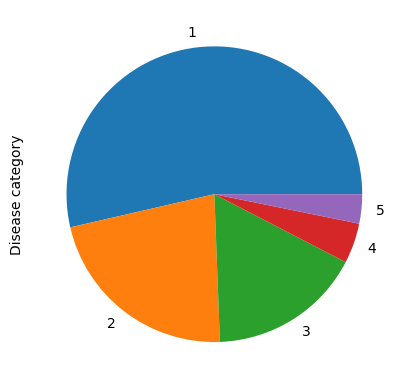

In [ ]:
# 分類標籤
CLASSES = ["Phonotrauma", "Incomplete glottic closure", "Vocal palsy", "Neoplasm", "Normal"]
df['Disease category'].value_counts().plot.pie()
df['Disease category'].value_counts()

In [ ]:
# 樣本權重 sample weight  (for imbalance data)
df['sample_weight'] = class_weight.compute_sample_weight('balanced', y=df['Disease category'])
df

,ID,Sex,Age,Disease category,Narrow pitch range,Decreased volume,Fatigue,Dryness,Lumping,heartburn,...,Noise at work,Occupational vocal demand,Diabetes,Hypertension,CAD,Head and Neck Cancer,Head injury,CVA,Voice handicap index - 10,sample_weight
0,1202f15,2,39,1,1,1,1,1,1,0,...,3,1,0,0,0,0,0,0,22.0,0.373134
1,0600ve0,1,69,2,1,1,1,1,0,0,...,1,3,0,0,0,0,0,1,19.0,0.909091
2,1001o7l,2,59,2,1,1,1,1,0,0,...,3,4,0,0,0,0,0,0,18.0,0.909091
3,1201c1t,2,47,1,1,0,1,1,1,0,...,1,1,0,0,0,0,0,0,27.0,0.373134
4,0402jvt,1,87,1,0,0,0,0,0,0,...,1,4,0,1,0,0,0,0,16.0,0.373134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0G00ftn,1,75,3,0,0,0,0,0,0,...,1,4,1,1,1,0,0,0,21.0,1.190476
996,1201pkr,1,40,4,0,0,1,0,0,0,...,1,2,0,0,0,0,0,0,21.0,4.545455
997,0202p64,2,68,3,0,1,1,0,0,0,...,2,1,0,0,0,0,0,0,27.0,1.190476
998,12021au,2,42,2,0,0,1,1,1,0,...,1,2,0,0,0,0,0,0,12.0,0.909091


## 1.1 添加音檔路徑

In [ ]:
# 檔案名稱為 {ID}.wav
training_voice_dir = "/content/gdrive/Shareddrives/1112_AI智慧醫療三日工作坊/教材/Training Dataset/training_voice_data"
df['path'] = df['ID'].map(lambda x: f"{training_voice_dir}/{x}.wav")
df

,ID,Sex,Age,Disease category,Narrow pitch range,Decreased volume,Fatigue,Dryness,Lumping,heartburn,...,Occupational vocal demand,Diabetes,Hypertension,CAD,Head and Neck Cancer,Head injury,CVA,Voice handicap index - 10,sample_weight,path
0,1202f15,2,39,1,1,1,1,1,1,0,...,1,0,0,0,0,0,0,22.0,0.373134,/content/gdrive/Shareddrives/1112_AI智慧醫療三日工作坊/...
1,0600ve0,1,69,2,1,1,1,1,0,0,...,3,0,0,0,0,0,1,19.0,0.909091,/content/gdrive/Shareddrives/1112_AI智慧醫療三日工作坊/...
2,1001o7l,2,59,2,1,1,1,1,0,0,...,4,0,0,0,0,0,0,18.0,0.909091,/content/gdrive/Shareddrives/1112_AI智慧醫療三日工作坊/...
3,1201c1t,2,47,1,1,0,1,1,1,0,...,1,0,0,0,0,0,0,27.0,0.373134,/content/gdrive/Shareddrives/1112_AI智慧醫療三日工作坊/...
4,0402jvt,1,87,1,0,0,0,0,0,0,...,4,0,1,0,0,0,0,16.0,0.373134,/content/gdrive/Shareddrives/1112_AI智慧醫療三日工作坊/...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0G00ftn,1,75,3,0,0,0,0,0,0,...,4,1,1,1,0,0,0,21.0,1.190476,/content/gdrive/Shareddrives/1112_AI智慧醫療三日工作坊/...
996,1201pkr,1,40,4,0,0,1,0,0,0,...,2,0,0,0,0,0,0,21.0,4.545455,/content/gdrive/Shareddrives/1112_AI智慧醫療三日工作坊/...
997,0202p64,2,68,3,0,1,1,0,0,0,...,1,0,0,0,0,0,0,27.0,1.190476,/content/gdrive/Shareddrives/1112_AI智慧醫療三日工作坊/...
998,12021au,2,42,2,0,0,1,1,1,0,...,2,0,0,0,0,0,0,12.0,0.909091,/content/gdrive/Shareddrives/1112_AI智慧醫療三日工作坊/...


## 1.2 讀取音檔

嗓音診斷分類： Vocal palsy
音訊檔案路徑： /content/gdrive/Shareddrives/1112_AI智慧醫療三日工作坊/教材/Training Dataset/training_voice_data/1001ghu.wav
音訊取樣頻率(sampling rate) = 11025 Hz    array shape = (33075,)    dtype = float32


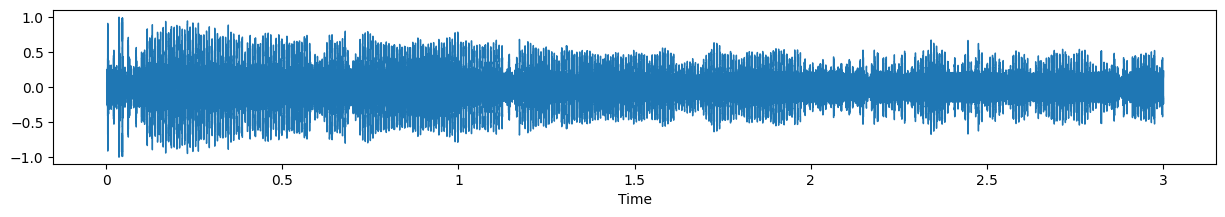

In [ ]:
def load_wav(path, target_sr=11025, fix_length=None, normalize=True):
    """Read and normalize a wave file to np.array"""
    waveform, sr = librosa.load(path)
    if waveform.ndim > 1:  # convert to mono
        waveform = librosa.to_mono(waveform)
    if sr != target_sr:  # resmapling to target_sr
        waveform = librosa.resample(waveform, orig_sr=sr, target_sr=target_sr)
        sr = target_sr
    if fix_length != None:  # fix array length
        waveform = librosa.util.fix_length(waveform, size=fix_length)
    if normalize:
        waveform = waveform / np.abs(waveform).max()
    return waveform, sr

# function test:
idx = np.random.choice(df.index, size=1)[0]  # 隨機選一個資料索引
print("嗓音診斷分類：", CLASSES[df.loc[idx, 'Disease category'] - 1])
path = df.loc[idx, 'path']
print("音訊檔案路徑：", path)

waveform, sr = load_wav(path)

# show
print(f"音訊取樣頻率(sampling rate) = {sr} Hz    array shape = {waveform.shape}    dtype = {waveform.dtype}")
fig = plt.figure(figsize=(15, 2))
librosa.display.waveshow(waveform, sr=sr)
plt.show()
display.display(display.Audio(waveform, rate=sr))

音訊取樣頻率(sampling rate) = 11025 Hz    array shape = (33075,)    dtype = float64


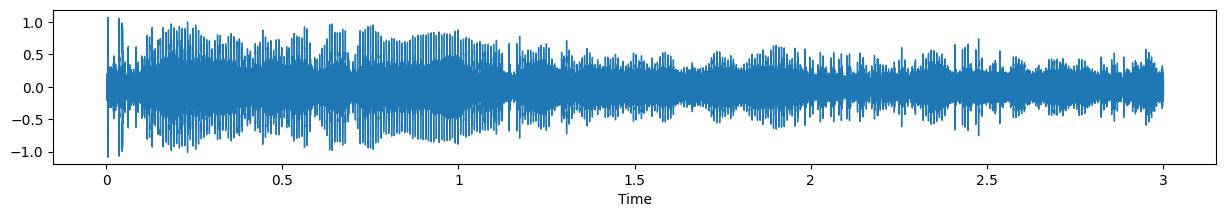

In [ ]:
def high_pass_filter(y, sr, critical_freq=100): 
    b, a = signal.butter(10, critical_freq/(sr/2), btype='highpass')
    yf = signal.lfilter(b, a, y)
    return yf

# function test:
filtered = high_pass_filter(waveform, sr)
# show
print(f"音訊取樣頻率(sampling rate) = {sr} Hz    array shape = {filtered.shape}    dtype = {filtered.dtype}")
fig = plt.figure(figsize=(15, 2))
librosa.display.waveshow(filtered, sr=sr)
plt.show()
display.display(display.Audio(filtered, rate=sr))

音訊取樣頻率(sampling rate) = 11025 Hz    array shape = (33075,)    dtype = float64


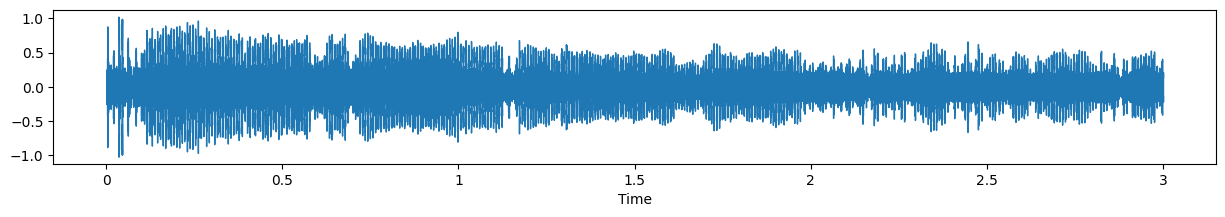

In [ ]:
def low_pass_filter(y, sr, critical_freq=5000): 
    b, a = signal.butter(10, critical_freq/(sr/2), btype='lowpass')
    yf = signal.lfilter(b, a, y)
    return yf

# function test:
filtered = low_pass_filter(waveform, sr)
# show
print(f"音訊取樣頻率(sampling rate) = {sr} Hz    array shape = {filtered.shape}    dtype = {filtered.dtype}")
fig = plt.figure(figsize=(15, 2))
librosa.display.waveshow(filtered, sr=sr)
plt.show()
display.display(display.Audio(filtered, rate=sr))

## 1.3 音訊轉2D特徵圖
n_fft ,hop_length 到底什麼 https://ithelp.ithome.com.tw/articles/10260738?sc=iThelpR

S shape = (1025, 65) [ 0.00 ~ 119.98 ]


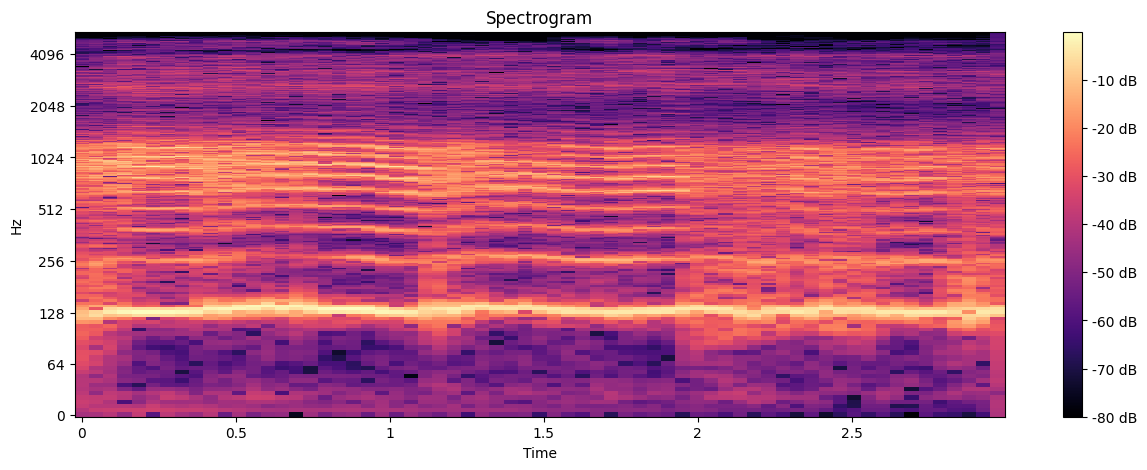

In [ ]:
#@title 頻譜圖 (Spectrogram)
# 短時間傅立葉轉換 (Short-time Fourier Transform, STFT)
# https://librosa.org/doc/main/generated/librosa.stft.html
def wav_to_stft(waveform, sr):
    n_fft = 2048  # 音框長度 (音框長度 x 取樣率Hz = 對應的時間長度sec)
    S = np.abs(librosa.stft(waveform, n_fft=n_fft))
    return S #/ S.max()  # normalized output

# function test:
S = wav_to_stft(waveform, sr)
print(f"S shape = {S.shape} [ {S.min():.2f} ~ {S.max():.2f} ]")
# plot
fig = plt.figure(figsize=(15, 5))
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), sr=sr, y_axis='log', x_axis='time')
# librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), sr=sr, y_axis='linear', x_axis='time')
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram")
plt.show()

mel_S shape = (80, 65) [ 0.00 ~ 624.97 ]


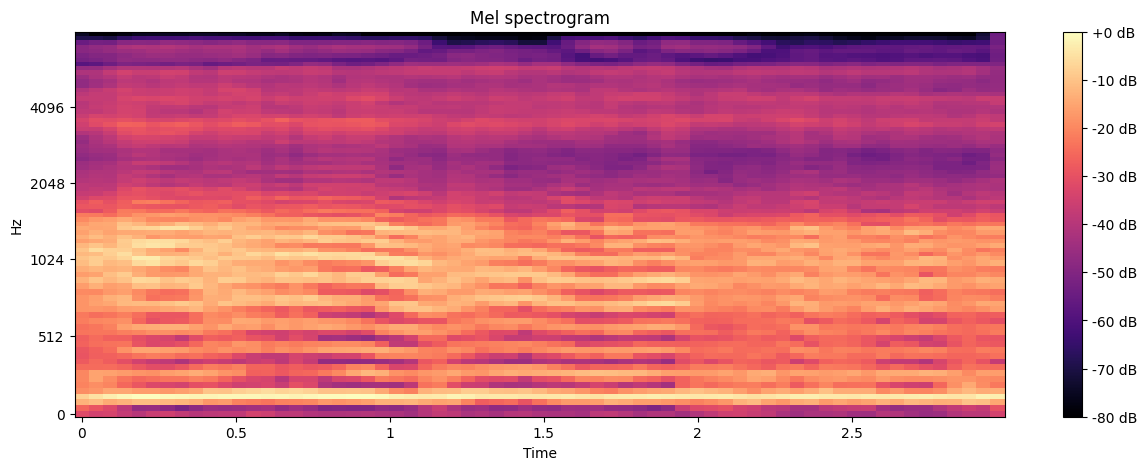

In [ ]:
#@title 梅爾頻譜圖 (Mel Spectrogram)
# https://medium.com/analytics-vidhya/understanding-the-mel-spectrogram-fca2afa2ce53
# https://librosa.org/doc/main/generated/librosa.feature.melspectrogram.html
def wav_to_mel_spec(waveform, sr):
    n_fft = 2048  # 音框長度 (音框長度 x 取樣率Hz = 對應的時間長度sec)
    n_mels = 80  # 頻帶數量
    fmax = 5500  # 最高頻率
    mel_S = librosa.feature.melspectrogram(y=waveform, sr=sr, n_fft=n_fft, n_mels=n_mels, fmax=fmax)
    return mel_S #/ mel_S.max()  # normalized output

# function test:
mel_S = wav_to_mel_spec(waveform, sr)
print(f"mel_S shape = {mel_S.shape} [ {mel_S.min():.2f} ~ {mel_S.max():.2f} ]")
# plot
fig = plt.figure(figsize=(15, 5))
librosa.display.specshow(librosa.power_to_db(mel_S, ref=np.max), sr=sr, y_axis='mel', x_axis='time', fmax=8000)
plt.colorbar(format="%+2.0f dB")
plt.title("Mel spectrogram")
plt.show()

/usr/local/lib/python3.10/dist-packages/librosa/feature/spectral.py:2157: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


mfccs shape = (20, 65) [ -151.18 ~ 202.47 ]


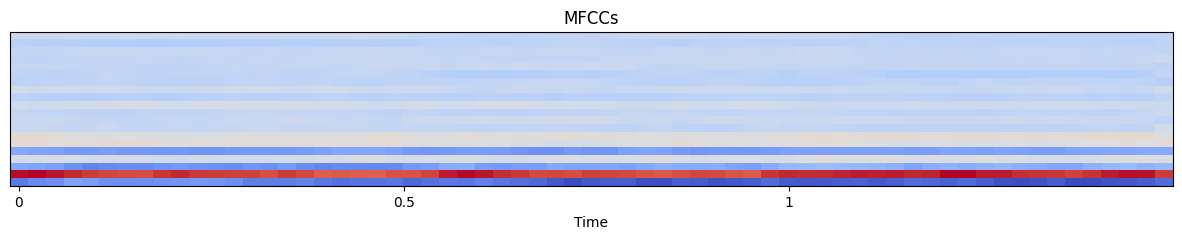

In [ ]:

#@title 梅爾頻率倒譜係數 (Mel-frequency cepstral coefficients, MFCC)
# https://librosa.org/doc/main/generated/librosa.feature.mfcc.html
def wav_to_mfcc(waveform, sr):
    n_fft = 2048  # 音框長度 (音框長度 x 取樣率Hz = 對應的時間長度sec)
    n_mels = 128  # 頻帶數量
    fmax = 8000  # 最高頻率
    mfccs = librosa.feature.mfcc(y=waveform, sr=sr, n_mfcc=20, n_fft=n_fft, n_mels=n_mels, fmax=fmax)
    return mfccs

# function test:
mfccs = wav_to_mfcc(waveform, sr)
print(f"mfccs shape = {mfccs.shape} [ {mfccs.min():.2f} ~ {mfccs.max():.2f} ]")
# plot
fig = plt.figure(figsize=(15, 2))
librosa.display.specshow(mfccs, x_axis='time')
plt.title("MFCCs")
plt.show()

mfcc_delta shape = (40, 65) [ -151.18 ~ 202.47 ]


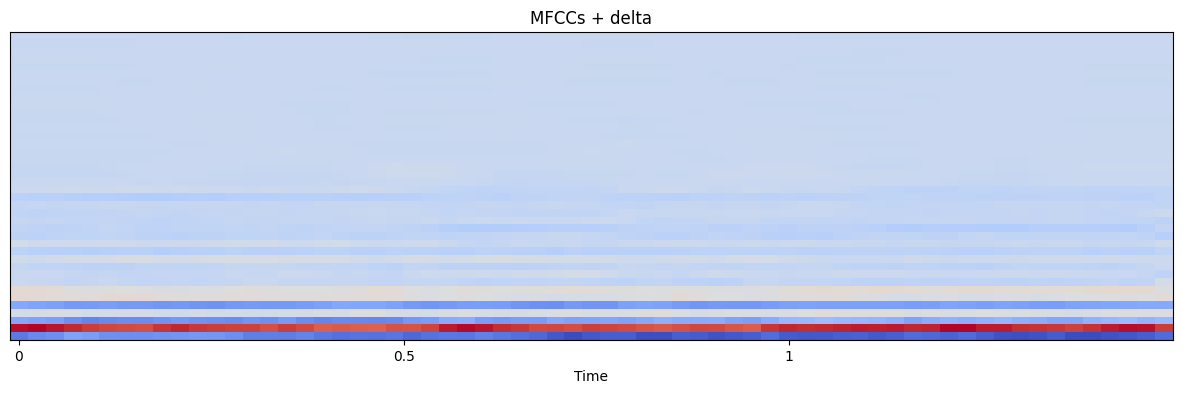

In [ ]:

# 梅爾頻率倒譜係數 + 差量 特徵
# https://blog.maxkit.com.tw/2019/
def wav_to_mfccs_delta(waveform, sr):  
    n_fft = 2048  # 音框長度 (音框長度 x 取樣率Hz = 對應的時間長度sec)
    n_mels = 128  # 頻帶數量
    fmax = 8000  # 最高頻率
    mfcc_feature = librosa.feature.mfcc(y=waveform, sr=sr, n_mfcc=20, n_fft=n_fft, n_mels=n_mels, fmax=fmax)
    delta_mfcc_feature = librosa.feature.delta(mfcc_feature)
    mfcc_delta = np.concatenate((mfcc_feature, delta_mfcc_feature))
    return mfcc_delta

# function test:
mfcc_delta = wav_to_mfccs_delta(waveform, sr=sr)
print(f"mfcc_delta shape = {mfcc_delta.shape} [ {mfcc_delta.min():.2f} ~ {mfcc_delta.max():.2f} ]")
# plot
fig = plt.figure(figsize=(15, 4))
librosa.display.specshow(mfcc_delta, x_axis='time')
plt.title("MFCCs + delta")
plt.show()

## 1.4 處理 目標欄位 (target)

In [ ]:
df_trans = pd.get_dummies(df, columns=['Disease category'])
df_trans

,ID,Sex,Age,Narrow pitch range,Decreased volume,Fatigue,Dryness,Lumping,heartburn,Choking,...,Head injury,CVA,Voice handicap index - 10,sample_weight,path,Disease category_1,Disease category_2,Disease category_3,Disease category_4,Disease category_5
0,1202f15,2,39,1,1,1,1,1,0,0,...,0,0,22.0,0.373134,/content/gdrive/Shareddrives/1112_AI智慧醫療三日工作坊/...,1,0,0,0,0
1,0600ve0,1,69,1,1,1,1,0,0,1,...,0,1,19.0,0.909091,/content/gdrive/Shareddrives/1112_AI智慧醫療三日工作坊/...,0,1,0,0,0
2,1001o7l,2,59,1,1,1,1,0,0,1,...,0,0,18.0,0.909091,/content/gdrive/Shareddrives/1112_AI智慧醫療三日工作坊/...,0,1,0,0,0
3,1201c1t,2,47,1,0,1,1,1,0,0,...,0,0,27.0,0.373134,/content/gdrive/Shareddrives/1112_AI智慧醫療三日工作坊/...,1,0,0,0,0
4,0402jvt,1,87,0,0,0,0,0,0,0,...,0,0,16.0,0.373134,/content/gdrive/Shareddrives/1112_AI智慧醫療三日工作坊/...,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0G00ftn,1,75,0,0,0,0,0,0,1,...,0,0,21.0,1.190476,/content/gdrive/Shareddrives/1112_AI智慧醫療三日工作坊/...,0,0,1,0,0
996,1201pkr,1,40,0,0,1,0,0,0,1,...,0,0,21.0,4.545455,/content/gdrive/Shareddrives/1112_AI智慧醫療三日工作坊/...,0,0,0,1,0
997,0202p64,2,68,0,1,1,0,0,0,0,...,0,0,27.0,1.190476,/content/gdrive/Shareddrives/1112_AI智慧醫療三日工作坊/...,0,0,1,0,0
998,12021au,2,42,0,0,1,1,1,0,1,...,0,0,12.0,0.909091,/content/gdrive/Shareddrives/1112_AI智慧醫療三日工作坊/...,0,1,0,0,0


In [ ]:
# 分類目標欄位
target_columns = ['Disease category_1', 'Disease category_2', 'Disease category_3', 'Disease category_4', 'Disease category_5']
print("目標欄位數量 =", len(target_columns))

目標欄位數量 = 5


## 1.5 資料及分割 (train/valid)
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [ ]:
# 按診斷分類 切分 train/valid
train_index, valid_index = train_test_split(df_trans.index, train_size=0.8, random_state=333, stratify=df['Disease category'])
print('train_index shape =', train_index.shape)
print('valid_index shape =', valid_index.shape)

train_index shape = (800,)
valid_index shape = (200,)


## 1.6 樣本產生器(generator)
https://www.tensorflow.org/api_docs/python/tf/data/Dataset

In [ ]:
# define tensorflow function
fix_length = 22050 * 2  # 限制音訊長度 (sampling_rate * 2 sec)

def train_preprocessing(idx):
    def py_preproc(idx):  # input tensor
        idx = idx.numpy()
        path = df_trans.loc[idx, 'path']
        waveform, sr = load_wav(path, fix_length=fix_length, normalize=True)  # fix length
        # data augmentation [TODO]
        feats2D = wav_to_mel_spec(waveform, sr=sr)  # 選一個 2D特徵 轉換的方式
        label = df_trans.loc[idx, target_columns].values
        sample_weight = df_trans.loc[idx, 'sample_weight']
        return feats2D[:, :, np.newaxis], label, sample_weight

    feats2D, label, sample_weight = tf.py_function(func=py_preproc, inp=[idx], Tout=[tf.float32, tf.float32, tf.float32])
    return feats2D, label, sample_weight  # tensor output

def valid_preprocessing(idx):  # same as train_preprocessing but without augmentation and sample_weight
    def py_preproc(idx):  # input tensor
        idx = idx.numpy()
        path = df_trans.loc[idx, 'path']
        waveform, sr = load_wav(path, fix_length=fix_length, normalize=True)  # fix length
        feats2D = wav_to_mel_spec(waveform, sr=sr)  # 選一個 2D特徵 轉換的方式
        label = df_trans.loc[idx, target_columns].values
        return feats2D[:, :, np.newaxis], label

    feats2D, label = tf.py_function(func=py_preproc, inp=[idx], Tout=[tf.float32, tf.float32])
    return feats2D, label  # tensor output

# tf function test:
idx = np.random.choice(df.index, size=1)[0]  # 隨機選一個資料索引
X, y, sw = train_preprocessing(idx)
print(f"X shape={X.shape} dtype={X.dtype.name}")
print("y =", y)
print("sample_weight =", sw)

X shape=(80, 87, 1) dtype=float32
y = tf.Tensor([0. 0. 1. 0. 0.], shape=(5,), dtype=float32)
sample_weight = tf.Tensor(1.1904762, shape=(), dtype=float32)


In [ ]:
#@title 預設標題文字
# prepare dataset as generator
batch_size = 128
autotune = tf.data.experimental.AUTOTUNE

train_generator = tf.data.Dataset.from_tensor_slices(train_index)  # train index
train_generator = train_generator.shuffle(len(train_index), reshuffle_each_iteration=True) \
                                .map(train_preprocessing, num_parallel_calls=4) \
                                .batch(batch_size) \
                                .prefetch(2)

valid_generator = tf.data.Dataset.from_tensor_slices(valid_index)  # valid index
valid_generator = valid_generator.map(valid_preprocessing, num_parallel_calls=4) \
                                .batch(batch_size) \
                                .prefetch(2)

# train_generator test:
for batch_x, batch_y, batch_sw in train_generator:
    print("batch_x shape:", batch_x.shape)
    print("batch_y shape:", batch_y.shape)
    print("batch_sw shape:", batch_sw.shape)
    break

batch_x shape: (128, 80, 87, 1)
batch_y shape: (128, 5)
batch_sw shape: (128,)


# 2 模型 2D Model

In [ ]:
def residual_block(x, filters, conv_num=3, activation="relu"):
    # Shortcut
    s = layers.Conv2D(filters, 1, padding="same")(x)
    for i in range(conv_num - 1):
      #x = layers.BatchNormalization()(x)
      x = layers.Conv2D(filters, 3, padding="same")(x)
      x = layers.Activation(activation)(x)
    x = layers.Conv2D(filters, 3, padding="same")(x)
      #x = layers.BatchNormalization()(x)
    x = layers.Add()([x, s])
    x = layers.Activation(activation)(x)
    return layers.MaxPool2D(pool_size=2, strides=2)(x)

def build_model(input_shape, num_classes=5):
    inputs = layers.Input(shape=input_shape, name="wave")

    x = residual_block(inputs, 16, 2)
    x = residual_block(x, 32, 2)
    x = residual_block(x, 64, 3)
    x = residual_block(x, 128, 3)
    x = residual_block(x, 256, 3)
    x = residual_block(x, 256, 3)


    x = layers.Flatten()(x)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dense(256, activation="relu")(x)

    logits = layers.Dense(num_classes, name="logits")(x)

    return Model(inputs=inputs, outputs=logits, name=f"0518pony_cnn_model_01")  # <-- 為模型命名(存檔資料夾名稱)

# Build model.
K.clear_session()
model = build_model(input_shape=X.shape)
model.summary(line_length=160)

Model: "0518pony_cnn_model_01"
________________________________________________________________________________________________________________________________________________________________
 Layer (type)                                       Output Shape                        Param #            Connected to                                         
 wave (InputLayer)                                  [(None, 80, 87, 1)]                 0                  []                                                   
                                                                                                                                                                
 conv2d_1 (Conv2D)                                  (None, 80, 87, 16)                  160                ['wave[0][0]']                                       
                                                                                                                                                                
 ac

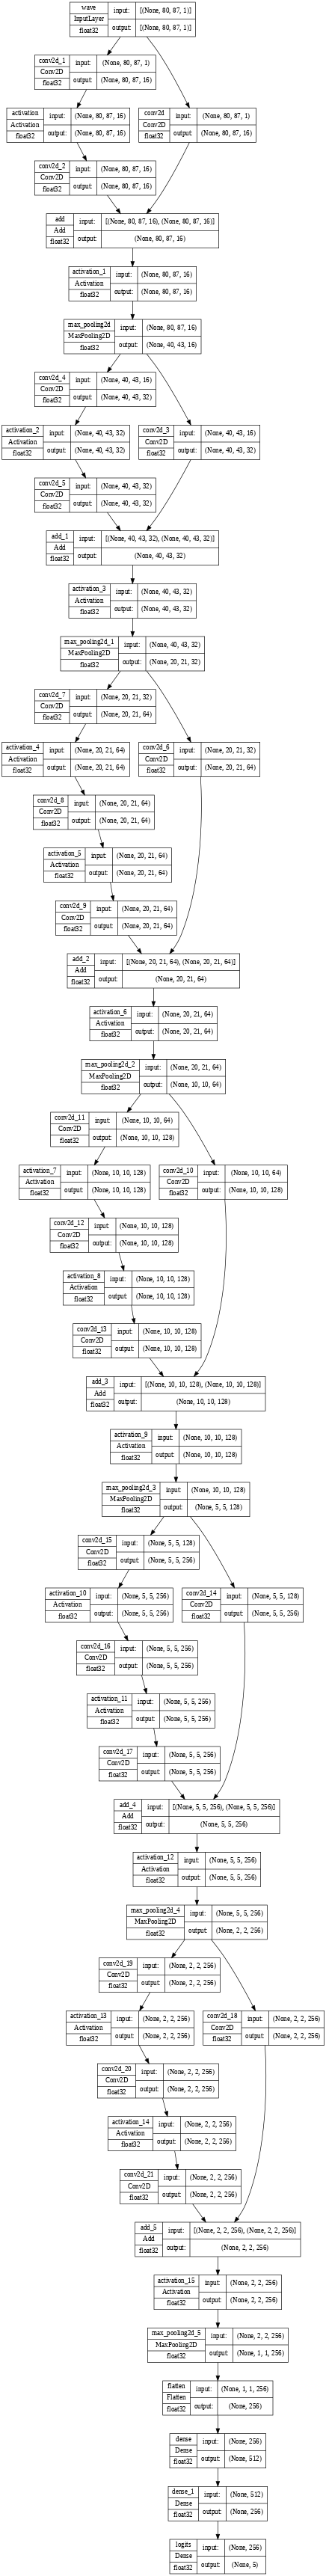

In [ ]:
# 看看設計架構
plot_model(model, to_file="/tmp/model.png", show_shapes=True, show_dtype=True, show_layer_names=True, dpi=48)

In [ ]:
def f1(y_true, y_pred):    
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives+K.epsilon())    
        return recall 
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives+K.epsilon())
        return precision 
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))
    #f1 = 2 * ((precision * recall) / (precision + recall + K.epsilon()))
    #f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    #return f1

# Compile model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              metrics=[tf.keras.metrics.AUC(name='auc'), 
                       f1, 
                       ])

# 3 訓練 Training

In [ ]:
# 建立模型儲存資料夾
model_dir = f"{my_working_root}/model/{model.name}"  # <-- 指定模型儲存的資料夾
os.makedirs(model_dir, exist_ok=True)

# Define callbacks
mc = callbacks.ModelCheckpoint(filepath= model_dir + '/best_model.h5', 
                               monitor='val_f1', mode='max', save_best_only=True)
rl = callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.5, patience=15)
es = callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=30)

# 開始訓練
EPOCHS = 30
history = model.fit(train_generator, 
                    epochs=EPOCHS, 
                    validation_data=valid_generator, 
                    callbacks=[mc, rl, es], 
                    )

Epoch 1/30
7/7 [==============================] - 159s 19s/step - loss: 56.4209 - auc: 0.4549 - f1: 0.2057 - val_loss: 3.5320 - val_auc: 0.4415 - val_f1: 0.0385 - lr: 0.0010
Epoch 2/30
7/7 [==============================] - 21s 3s/step - loss: 3.6171 - auc: 0.5318 - f1: 0.1679 - val_loss: 2.1040 - val_auc: 0.5440 - val_f1: 0.2511 - lr: 0.0010
Epoch 3/30
7/7 [==============================] - 21s 3s/step - loss: 2.1585 - auc: 0.4993 - f1: 0.1458 - val_loss: 1.4970 - val_auc: 0.6885 - val_f1: 0.2825 - lr: 0.0010
Epoch 4/30
7/7 [==============================] - 20s 3s/step - loss: 1.7360 - auc: 0.5455 - f1: 0.1388 - val_loss: 1.5677 - val_auc: 0.5274 - val_f1: 0.1188 - lr: 0.0010
Epoch 5/30
7/7 [==============================] - 20s 3s/step - loss: 1.5918 - auc: 0.5232 - f1: 0.0698 - val_loss: 1.6564 - val_auc: 0.4728 - val_f1: 0.0263 - lr: 0.0010
Epoch 6/30
7/7 [==============================] - 19s 3s/step - loss: 1.4635 - auc: 0.5129 - f1: 0.0441 - val_loss: 1.5251 - val_auc: 0.5540 -

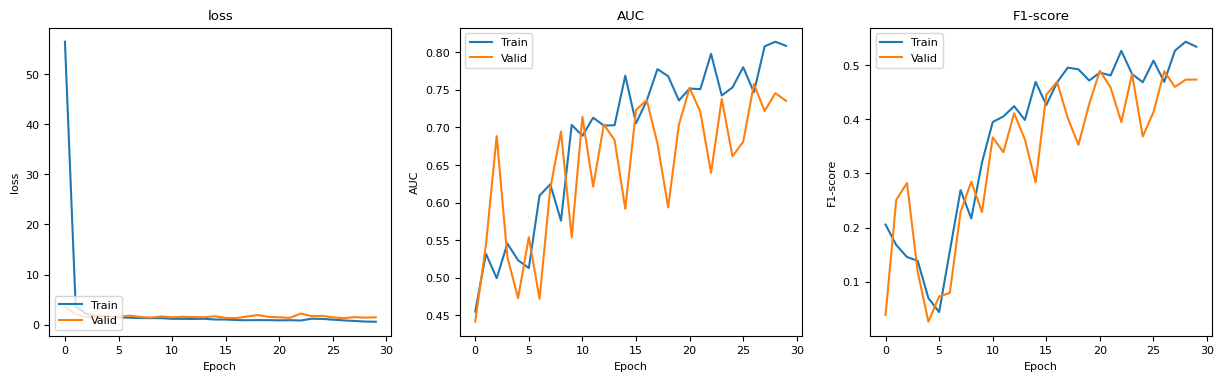

In [ ]:
#@title 訓練曲線
plt.rcParams.update({'font.size': 8})
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

# Plot training & validation accuracy values
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set_title('loss')
ax1.set(ylabel='loss', xlabel='Epoch')
ax1.legend(['Train', 'Valid'], loc='lower left')

# Plot training & validation loss values
ax2.plot(history.history['auc'])
ax2.plot(history.history['val_auc'])
ax2.set_title('AUC')
ax2.set(ylabel='AUC', xlabel='Epoch')
ax2.legend(['Train', 'Valid'], loc='upper left')

# Plot training & validation F1-score values
ax3.plot(history.history['f1'])
ax3.plot(history.history['val_f1'])
ax3.set_title('F1-score')
ax3.set(ylabel='F1-score', xlabel='Epoch')
ax3.legend(['Train', 'Valid'], loc='upper left')

plt.show()

In [ ]:
# 儲存模型 save model
h5_file_path = model_dir + "/epoch_end.h5"
model.save(h5_file_path)

# 4 評估 Evaluation

In [ ]:
# 讀取模型存檔
h5_file_path = model_dir + "/best_model.h5"
# h5_file_path = model_dir + "/epoch_end.h5"
model = load_model(h5_file_path, compile=False)

In [ ]:
# 預測 驗證集 predict valid_set eagerly
y_true = []
y_pred = []
for x, y in valid_generator:
    y_true.append(y)
    pred = model(x, training=False).numpy()
    y_pred.append(pred)
    print(".", end="")
print("Done!")

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
print("y_true shape:", y_true.shape)
print("y_pred shape:", y_pred.shape)

..Done!
y_true shape: (200, 5)
y_pred shape: (200, 5)


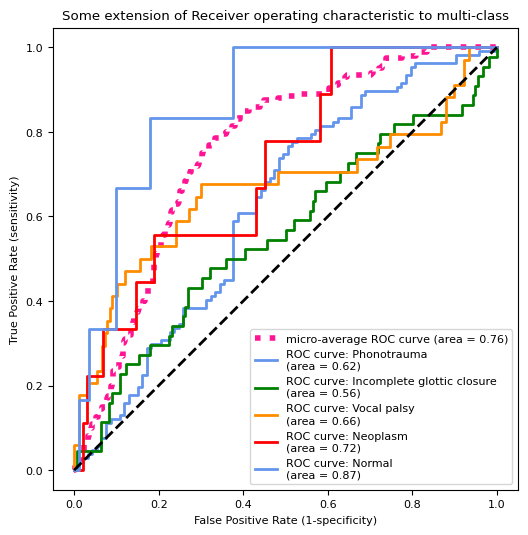

In [ ]:
#@title 畫出 ROC曲線
#@markdown https://zh.wikipedia.org/zh-tw/ROC%E6%9B%B2%E7%BA%BF
micro_avg = True  #@param {type:"boolean"}
marco_avg = False  #@param {type:"boolean"}

# 分別算出每一類別的 FPR(假陽率) TPR(真陽率) AUC(roc_curve底下的面積)
N_CLASSES = len(CLASSES)
fpr = dict()
tpr = dict()
lw = 2
roc_auc = dict()
for i in range(N_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

if micro_avg == True:
    # 計算 微觀平均曲線
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

if marco_avg == True:
    # 計算 宏觀平均曲線
    # Compute macro-average ROC curve and ROC area
    
    lw = 2
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(N_CLASSES)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(N_CLASSES):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= N_CLASSES

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    

#### 畫出所有 ROC 曲線 ####
plt.rcParams.update({'font.size': 8})
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)

if micro_avg == True:
    plt.plot(fpr["micro"], tpr["micro"],
            label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["micro"]),
            color='deeppink', linestyle=':', linewidth=4)

if marco_avg == True:
    plt.plot(fpr["macro"], tpr["macro"],
            label='macro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["macro"]),
            color='navy', linestyle=':', linewidth=4)

colors = cycle(['cornflowerblue', 'green', 'darkorange', 'red'])
for i, color in zip(range(N_CLASSES), colors):
    ax.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve: {0}\n(area = {1:0.2f})'
             ''.format(CLASSES[i], roc_auc[i]))

ax.plot([0, 1], [0, 1], 'k--', lw=lw)
ax.set(xlim=(0.0, 1.0), ylim=(0.0, 1.0))
ax.axis('equal')
ax.set_xlabel('False Positive Rate (1-specificity)')
ax.set_ylabel('True Positive Rate (sensitivity)')
ax.set_title('Some extension of Receiver operating characteristic to multi-class')
ax.legend(loc="lower right")
plt.show()

<Figure size 640x480 with 0 Axes>

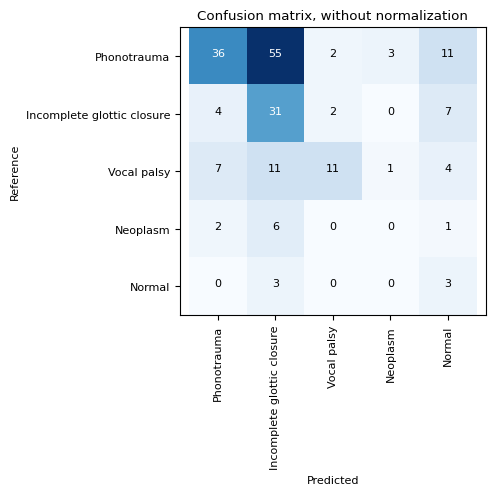

<Figure size 640x480 with 0 Axes>

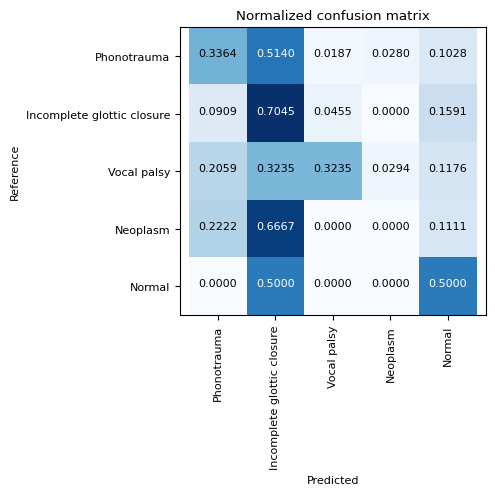

In [ ]:
#@title 畫出 混淆矩陣 confusion matrix
class_names = CLASSES
plt.rcParams.update({'font.size': 8})

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
    else:
#         print('Confusion matrix, without normalization')
        pass
#     print(cm)

    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    ax.axis('equal')
    plt.xticks(tick_marks, classes, rotation='vertical')
    plt.yticks(tick_marks, classes)

    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('Reference')
    ax.set_xlabel('Predicted')
    plt.tight_layout()

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))  #
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix and savefig
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()
# Plot normalized confusion matrix and savefig
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [ ]:
#@title 多分類報告 classification report
report = classification_report(y_true.argmax(axis=1), y_pred.argmax(axis=1), target_names=CLASSES, digits=4)
print(report)

                            precision    recall  f1-score   support

               Phonotrauma     0.7347    0.3364    0.4615       107
Incomplete glottic closure     0.2925    0.7045    0.4133        44
               Vocal palsy     0.7333    0.3235    0.4490        34
                  Neoplasm     0.0000    0.0000    0.0000         9
                    Normal     0.1154    0.5000    0.1875         6

                  accuracy                         0.4050       200
                 macro avg     0.3752    0.3729    0.3023       200
              weighted avg     0.5855    0.4050    0.4198       200



In [ ]:
#@title UAR (Unweighted Average Recall)
uar = recall_score(y_true.argmax(axis=1), y_pred.argmax(axis=1), average='macro')
print("Validation UAR (Unweighted Average Recall) :", uar)

Validation UAR (Unweighted Average Recall) : 0.37290469288820033


# 5 預測 Prediction (Test Data)
對測試資料作答 (public dataset / private dataset)

## 5.1 資料處理
(必須和訓練資料的處理流程相同)

In [ ]:
# 讀取資料表
df = pd.read_csv("/content/gdrive/Shareddrives/1112_AI智慧醫療三日工作坊/教材/Public Testing Dataset/test_datalist_public.csv")
df

In [ ]:
# 1.1 添加音檔路徑：檔案名稱為 {ID}.wav
test_voice_dir = "/content/gdrive/Shareddrives/1112_AI智慧醫療三日工作坊/教材/Public Testing Dataset/test_data_public"
df['path'] = df['ID'].map(lambda x: f"{test_voice_dir}/{x}.wav")
df

In [ ]:
# 樣本產生器(generator)
fix_length = 22050 * 2  # 限制音訊長度 (sampling_rate * 2 sec)

def test_preprocessing(idx):  # same as valid_preprocessing but without label
    def py_preproc(idx):  # input tensor
        idx = idx.numpy()
        path = df_trans.loc[idx, 'path']
        waveform, sr = load_wav(path, fix_length=fix_length, normalize=True)  # fix length
        feats2D = wav_to_mel_spec(waveform, sr=sr)  # 選一個 2D特徵 轉換的方式
        return feats2D[:, :, np.newaxis]

    feats2D = tf.py_function(func=py_preproc, inp=[idx], Tout=tf.float32)
    return feats2D  # tensor output

test_generator = tf.data.Dataset.from_tensor_slices(df.index)  # all test index
test_generator = test_generator.map(test_preprocessing, num_parallel_calls=4) \
                                .batch(batch_size=32) \
                                .prefetch(2)

# test_generator test:
for batch_x in test_generator:
    print("batch_x shape:", batch_x.shape)
    break

## 5.2 模型預測

In [ ]:
# 讀取模型存檔
h5_file_path = "/content/model/wav128-res2D_16_32_64_128_128-AP3_FlatD256D128-D5/best_model.h5"  # <-- 確認模型檔案存放的路徑
model = load_model(h5_file_path, compile=False)

In [ ]:
# 取得預測結果
y_pred = model.predict(test_generator)
print("y_pred shape =", y_pred.shape)
y_pred

In [ ]:
# 轉換為 疾病類別(1-5)
disease_category = np.argmax(y_pred, axis=1) + 1  # 取每筆最高的預測位置 + 1
disease_category

In [ ]:
# 準備競賽 提交檔案 submission
df_submit = pd.DataFrame()
df_submit['ID'] = df['ID']
df_submit['Category'] = disease_category
df_submit

In [ ]:
# 儲存為 .csv
csv_path = "/tmp/submission_public-Conv2D_0510.csv"  # <-- 修改名稱
df_submit.to_csv(csv_path, header=False, index=False, encoding='utf-8')  # 提交的csv格式不含 index 和 欄位

from google.colab import files
files.download(csv_path)